# Imports + settings

In [1]:
import os
os.chdir("../..")  # Move one level up  
print(os.getcwd())

/Users/malthepabst/Documents/GitHub/Thesis_Neurodiversity


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scripts.eda_func import plot_small_multiple_rois, test_dist, group_roi_heat_map

In [8]:
pd.options.mode.chained_assignment = None

In [9]:
num_of_rois = 7
roi_names = [f"ROI_{i+1}" for i in range(num_of_rois)]
meta_data = pd.read_csv(f'data.nosync/phenotypic/subjects_with_meta_{num_of_rois}.csv',
                         index_col= 'Unnamed: 0')
meta_data['Sub ID'] = meta_data['Sub ID'].apply(lambda x: str(x).zfill(7))
meta_data.shape

(660, 8)

In [10]:
meta_data.drop_duplicates(subset=['Sub ID', 'Dataset']).shape

(489, 8)

# Participant stats

### Take-aways

- The oldest participant is a 39 years old male participant, while the youngest is a 5 years old female participant.
- The highest IQ is at 148, while the lowest is at 67.
- There is some outliers in terms of age. Especeially at 30+.
- The TD-Other has the highest median (IQ), however there is only 6 participants in this group. With one female participant, and five male participants. 
- Most of the participants are at age 15 or below.
- There does not seem to be a clear clustering for the groups (diagnosis and sex), when looking at the age and IQ plots. 


In [11]:
participants = meta_data.drop_duplicates(subset=['Sub ID', 'Dataset'])
participants['Co-Diagnosis'] = participants['Co-Diagnosis'].replace({np.nan: ''})
participants['Co-Diagnosis'] = participants['Co-Diagnosis'].replace({np.nan: ''})
participants['Co-Diagnosis'] = participants['Co-Diagnosis'].apply(lambda x: '-'+x if x != '' else x)
participants['Diagnosis'] = participants['Diagnosis'] + participants['Co-Diagnosis']
participants.groupby(['Diagnosis', 'Sex']).agg({'Sex':['count'],
                                                                'IQ':['min', 'max', 'mean', 'std'], 
                                                                'Age':['min', 'max', 'mean', 'std']})


Sex     IQ                                   Age         \
                  count    min    max        mean        std     min    max   
Diagnosis  Sex                                                                
ADHD       Female    27   78.0  128.0  106.920000  12.724386   7.350  17.15   
           Male      76   73.0  134.0  105.945946  14.895887   7.260  17.61   
ADHD-Other Female     8   75.0  127.0  107.375000  15.574131   8.610  13.24   
           Male      33   82.0  132.0  103.562500  13.452275   7.240  17.37   
ASD        Female     7   78.0  134.0  101.428571  22.618997   5.220  34.76   
           Male      50   67.0  137.0  101.740000  17.090169   5.320  39.10   
ASD-ADHD   Female     3   74.0  132.0  106.666667  29.687259  10.000  38.76   
           Male      34   75.0  148.0  110.909091  17.782301   5.928  26.62   
ASD-Other  Female     3   91.0  118.0  102.333333  14.011900   6.750  24.41   
           Male      20   80.0  142.0  110.400000  16.368776   5.920  29.18   
TD         Female    75   80.0  140.0  109.690141  14.740219   5.907  29.13   
           Male     146   80.0  144.0  113.524476  13.479683   5.887  30.78   
TD-Other   Female     1  101.0  101.0  101.000000        NaN   8.100   8.10   
           Male       5   81.0  129.0  117.400000  20.427922   7.190  16.93   

                                         
                        mean        std  
Diagnosis  Sex                           
ADHD       Female  10.351481   2.553156  
           Male    11.201842   2.744991  
ADHD-Other Female  10.936250   1.807413  
           Male    11.537576   2.739780  
ASD        Female  14.442857   9.680924  
           Male    12.828120   6.696238  
ASD-ADHD   Female  20.174667  16.119519  
           Male    10.593176   5.348535  
ASD-Other  Female  17.990000   9.766944  
           Male    13.570500   5.769673  
TD         Female  12.996893   4.821956  
           Male    13.184863   5.333637  
TD-Other   Female   8.100000        NaN  
           Male    12.868000   3.963158

In [12]:
print('Participants with no sex:',participants[participants.Sex.isna()].shape[0])
print('Participants with no age:',participants[participants.Age.isna()].shape[0])
print('Participants with no IQ:',participants[participants.IQ.isna()].shape[0])

Participants with no sex: 1
Participants with no age: 0
Participants with no IQ: 13


In [13]:
#save the ones missing in order to remove from them train, test and validation split
to_remove = pd.concat([participants[participants.Sex.isna()],
                      participants[participants.Age.isna()],
                      participants[participants.IQ.isna()]])
to_remove = to_remove[['Sub ID', 'Dataset']]
to_remove['Exclude'] = True
to_remove.to_csv(f'data.nosync/phenotypic/missing_metadata.csv')

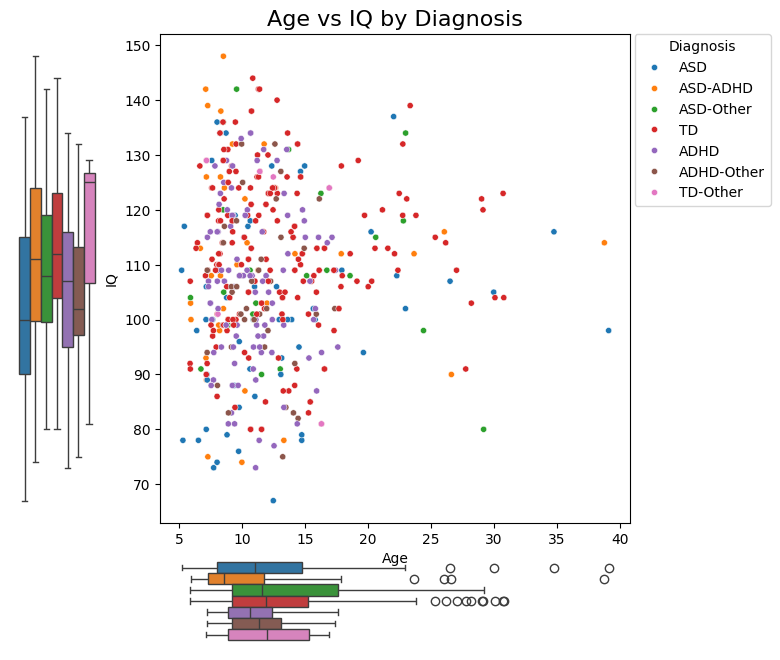

In [17]:
# Create a figure and define a custom gridspec layout
hue = 'Diagnosis'
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, 
                       width_ratios=[1, 5], 
                       height_ratios=[5, 1],
                       wspace=0.2, 
                       hspace=0.1)

# Create axes manually
ax_joint = fig.add_subplot(gs[0, 1])
ax_marg_x = fig.add_subplot(gs[1, 1], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[0, 0], sharey=ax_joint)

#Make scatter plot
sns.scatterplot(data=participants, 
                x="Age", 
                y="IQ",
                hue=hue, 
                s=20,
                ax=ax_joint)

#Make boxplots
sns.boxplot(data = participants,
            x = 'Age',
            hue = hue,
            ax=ax_marg_x,
            legend = False)

sns.boxplot(data = participants,
            y = 'IQ',
            hue = hue,
            ax=ax_marg_y,
            orientation="vertical",
            legend = False)

#Make legend appear outside of the scatter plot
handles, labels = ax_joint.get_legend_handles_labels()
ax_joint.legend(handles, labels,
                title=hue,
                bbox_to_anchor=(1.01, 1),
                loc='upper left',
                borderaxespad=0.)

ax_joint.set_title(f"Age vs IQ by {hue}",fontdict={'fontsize': 16})

#Remove axis
ax_marg_x.set_axis_off()
ax_marg_y.set_axis_off()

plt.savefig(f'notebooks/pics/dataset_stats/Participants_IQ_vs_age_{hue}.png', bbox_inches='tight', dpi = 300)

plt.show()


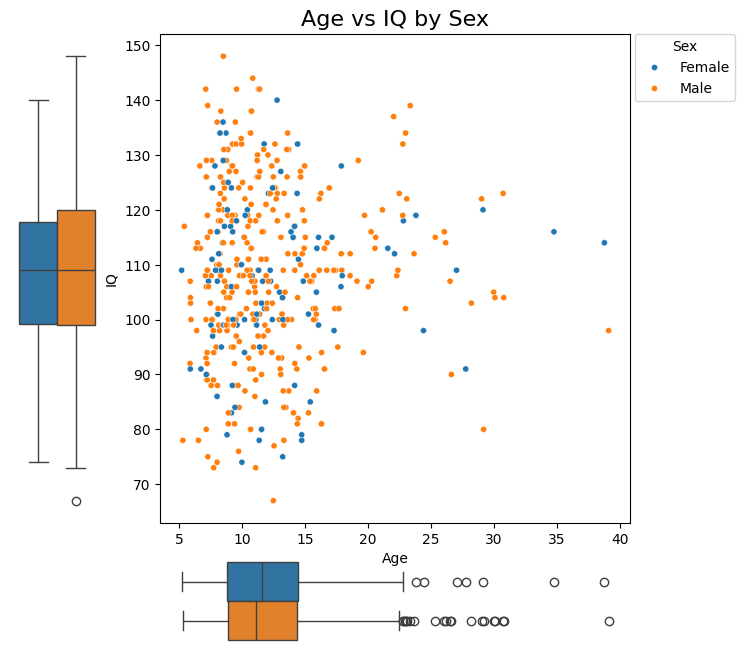

In [ ]:
# Create a figure and define a custom gridspec layout
hue = 'Sex'
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, 
                       width_ratios=[1, 5], 
                       height_ratios=[5, 1],
                       wspace=0.2, 
                       hspace=0.1)

# Create axes manually
ax_joint = fig.add_subplot(gs[0, 1])
ax_marg_x = fig.add_subplot(gs[1, 1], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[0, 0], sharey=ax_joint)

#Make scatter plot
sns.scatterplot(data=participants, 
                x="Age", 
                y="IQ",
                hue=hue, 
                s=20,
                ax=ax_joint)

#Make boxplots
sns.boxplot(data = participants,
            x = 'Age',
            hue = hue,
            ax=ax_marg_x,
            legend = False)

sns.boxplot(data = participants,
            y = 'IQ',
            hue = hue,
            ax=ax_marg_y,
            orientation="vertical",
            legend = False)

#Make legend appear outside of the scatter plot
handles, labels = ax_joint.get_legend_handles_labels()
ax_joint.legend(handles, labels,
                title=hue,
                bbox_to_anchor=(1.01, 1),
                loc='upper left',
                borderaxespad=0.)

ax_joint.set_title(f"Age vs IQ by {hue}",fontdict={'fontsize': 16})

#Remove axis
ax_marg_x.set_axis_off()
ax_marg_y.set_axis_off()

plt.savefig(f'notebooks/pics/dataset_stats/Participants_IQ_vs_age_{hue}.png', bbox_inches='tight', dpi = 300)

plt.show()


# Plot distribution of voxels

### Take-aways:
When we look at the std/mean ratio, we can see that most of the regions does not vary that much, 1-4%. However the ration for ROI 9 and 10, has a ratio of approxmiately 28\% and 33\%. When investigating ROI 5 along with the age, it is clear that there is some sort of correlation between the size of this ROI and the age.

Looking at the total number of voxels, plottet against age, we see that there is a correlation between age and the number of voxels. Mainly that the younger the subject, the more voxels there.

In [10]:
num_of_voxels = pd.read_csv(f'data.nosync/stats/num_of_voxels_pr_timestep_{num_of_rois}.csv',
                            index_col= 'Unnamed: 0')
num_of_voxels['Sub ID'] = num_of_voxels['Sub ID'].apply(lambda x: str(x).zfill(7))
num_of_voxels['Total'] = num_of_voxels[roi_names].sum(axis = 1)
num_of_voxels = pd.merge(num_of_voxels, meta_data, how="left", on=['Sub ID', 'Dataset'])
num_of_voxels['Full Diagnosis'] = num_of_voxels['Diagnosis'] + '+' + num_of_voxels['Co-Diagnosis'].apply(lambda x: str(x))
num_of_voxels['Full Diagnosis'] = num_of_voxels['Full Diagnosis'].apply(lambda x: x.replace('+nan', ''))
num_of_voxels = num_of_voxels.sort_values('Full Diagnosis')

In [11]:
stats_voxels = num_of_voxels[roi_names+['Total']].describe()

In [12]:
stats_voxels = stats_voxels.T.reset_index()
stats_voxels = stats_voxels[['index', 'mean', 'std']]
#Calculate the "ratio" to make them compareable between the ROIs
# Aka is the STD proportional bigger to the mean that other ROIs
stats_voxels['ratio'] = stats_voxels['std']/stats_voxels['mean']*100
stats_voxels

,index,mean,std,ratio
0,ROI_1,6129.250499,130.750971,2.133229
1,ROI_2,5660.366267,79.502540,1.404548
2,ROI_3,4308.987026,92.363185,2.143501
3,ROI_4,3995.587824,36.701223,0.918544
4,ROI_5,1646.654691,435.816203,26.466764
5,ROI_6,5419.527944,106.400849,1.963286
6,ROI_7,8319.417166,225.718477,2.713153
7,Total,35479.791417,889.830131,2.507991


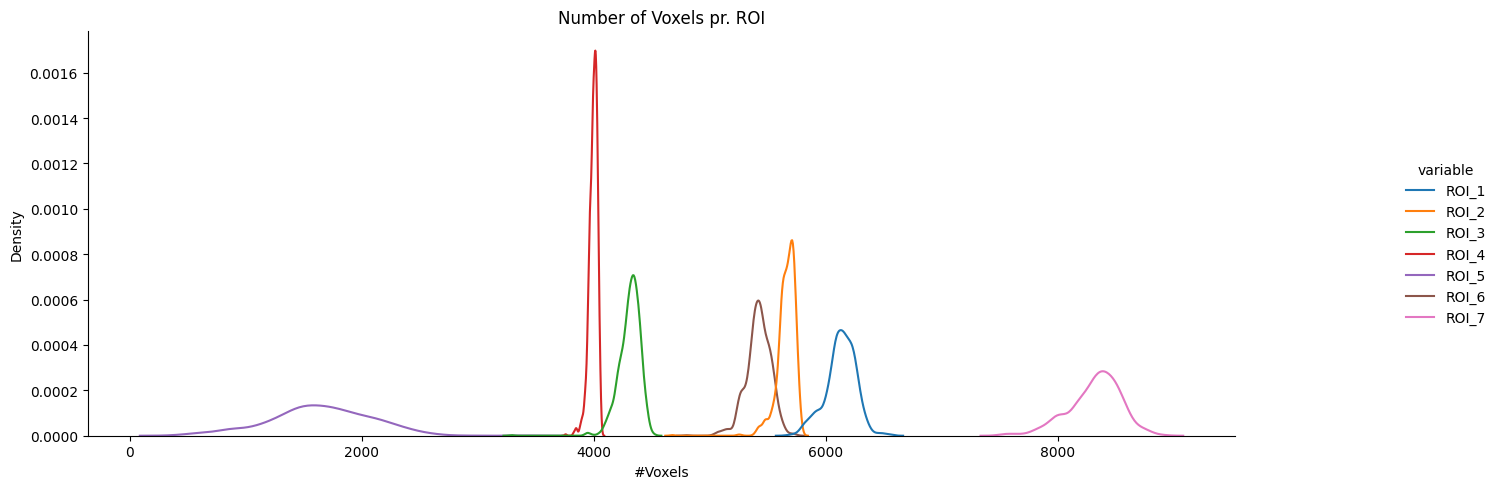

In [13]:
melted = num_of_voxels[roi_names].melt()

# setting the dimensions of the plot
p = sns.displot(data = melted,
            x='value',
            hue='variable',
            kind="kde")
p.set(title='Number of Voxels pr. ROI', xlabel= '#Voxels')
p.fig.set_figwidth(15)
p.fig.set_figheight(5)
p.tight_layout()
p.savefig(f'notebooks/pics/{num_of_rois} ROIs/Number_voxels_pr_roi_dist.png', dpi = 300)

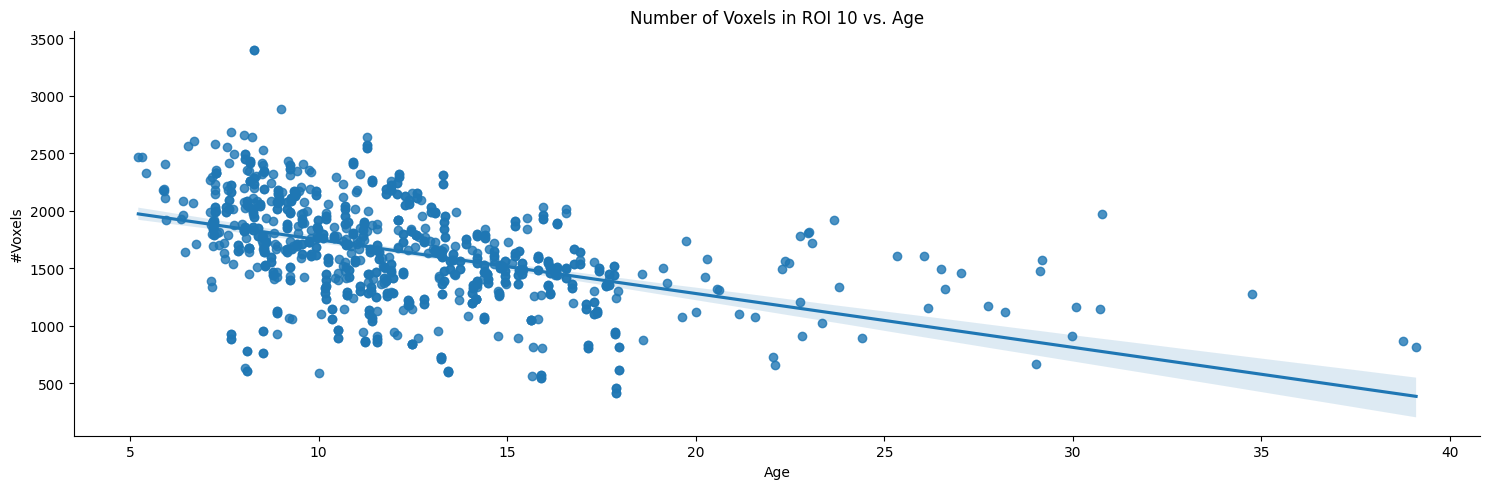

In [14]:
# setting the dimensions of the plot
p = sns.lmplot(data = num_of_voxels,
                    x='Age',
                    y='ROI_5',
                    truncate=True)
p.set(title='Number of Voxels in ROI 10 vs. Age', xlabel= 'Age', ylabel='#Voxels')
p.fig.set_figwidth(15)
p.fig.set_figheight(5)
p.tight_layout()
p.savefig(f'notebooks/pics/{num_of_rois} ROIs/ROI_10_voxels_age.png', dpi = 300)

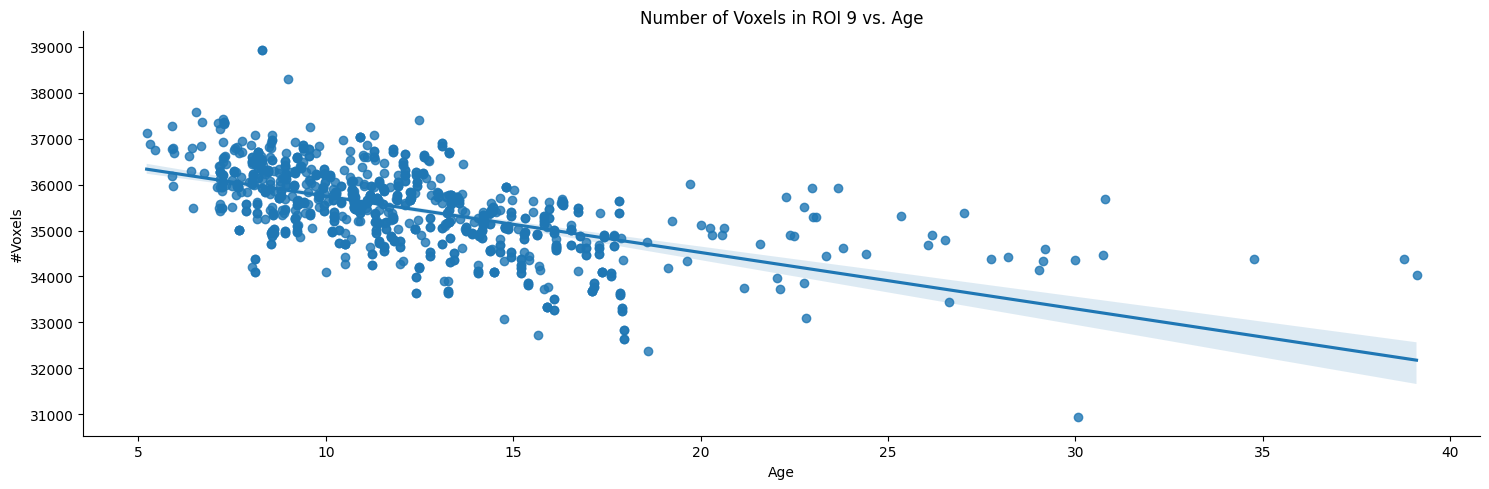

In [15]:
# setting the dimensions of the plot
p = sns.lmplot(data = num_of_voxels,
                    x='Age',
                    y='Total',
                    truncate=True)
p.set(title='Number of Voxels in ROI 9 vs. Age', xlabel= 'Age', ylabel='#Voxels')
p.fig.set_figwidth(15)
p.fig.set_figheight(5)
p.tight_layout()
p.savefig(f'notebooks/pics/{num_of_rois} ROIs/ROI_9_voxels_age.png', dpi = 300)

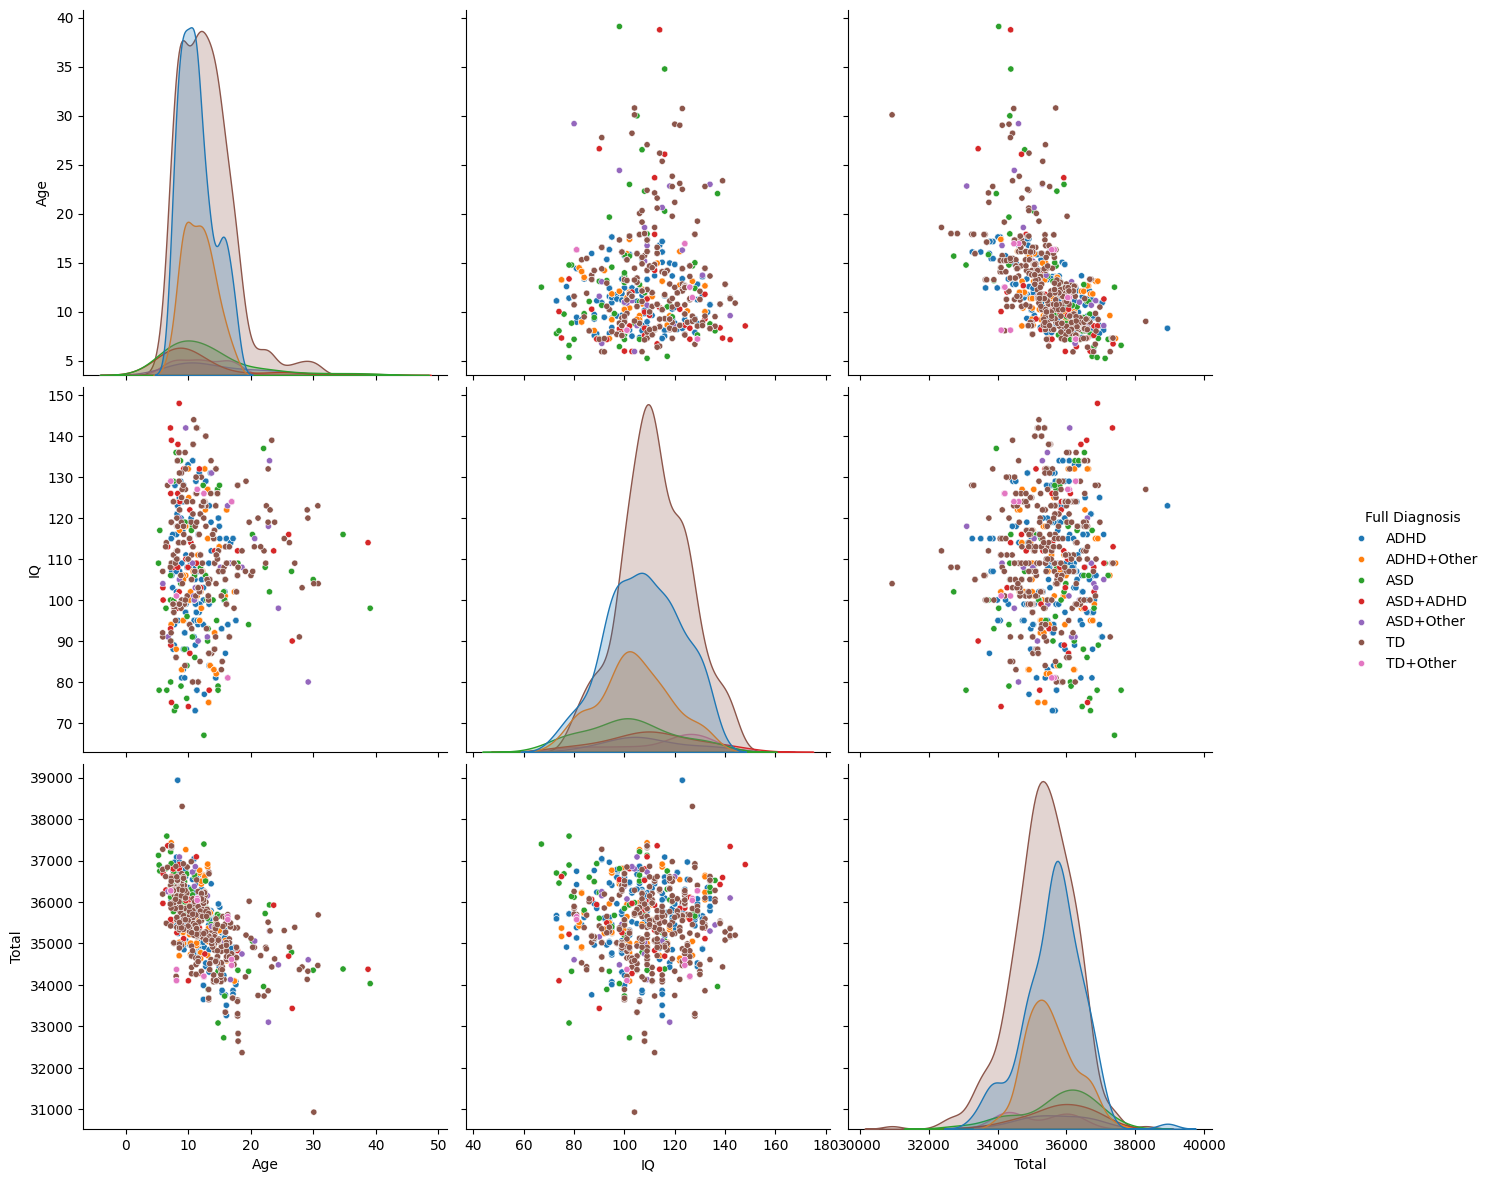

In [16]:
p = sns.pairplot(num_of_voxels[['Full Diagnosis','Age', 'IQ', 'Total']], hue="Full Diagnosis", plot_kws={'s': 20})

p.fig.set_figwidth(15)
p.fig.set_figheight(12)
p.tight_layout()
p.savefig(f'notebooks/pics/{num_of_rois} ROIs/Pairplot_metadata.png', dpi = 300)

# Binning and correlation

Here we calculate the means of each ROI, for different bin sizes through out the scan. E.g. we bin the scan into bins of size x, then we take the mean of the time step means for each bin. Afterwards the correlation between the ROIs means are calculated, pr. bin size. E.g calculating the correlation between the bins of size x. 

Take-aways: 
- When the bin size increases, the correlation values tends to get "polarized". This is true for all of the diagnosis. This could indicate that there might be some information in binning the timesteps, and combine the bins into multiple features.


In [17]:
meta_data.iloc[1].file_path.replace('clean','stats').replace('bold.npz', 'b.csv')
file_list = meta_data.copy()
file_list['file_path'] = file_list['file_path'].apply(lambda x: x.replace('clean','stats').replace('bold.npz', 'b.csv'))

file_list['Co-Diagnosis'] = file_list['Co-Diagnosis'].apply(lambda x: str(x))
file_list['Full Diagnosis'] = file_list['Diagnosis'] + '+' + file_list['Co-Diagnosis']
file_list['Full Diagnosis'] = file_list['Full Diagnosis'].apply(lambda x: x.replace('+nan','').replace('TD+Other', 'TD'))

In [18]:
bins = [1/(n+1) for n in range(17)]
#[10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 25, 29, 35, 44, 59, 88, 176]
#bin_sizes = list(set([int(round(i*176)) for i in bins]))
#bin_sizes.sort()

bin_sizes = [10, 15, 20, 25, 30, 35, 45, 60, 88, 172]


#Make for loop

final_data_dict = {}

#For each diagnosis
for diag in file_list['Full Diagnosis'].unique():
    print(diag)
    temp_subs = file_list[file_list['Full Diagnosis'] == diag]
    diag_data = []
    #for each subject
    for idx, row in temp_subs.iterrows():
        test_sub = pd.read_csv(row['file_path'], delimiter = ';', index_col = 'Unnamed: 0')
        scan_length = test_sub.shape[0]
        for bin in bin_sizes:
            time = 1
            #add each bin step
            for i in range(bin, scan_length, bin+1):
                means = test_sub.iloc[i-bin:i].mean().to_dict()
                means['Time'], means['Bin'], means['Subject'], means['Dataset'], means['Full Diagnosis'] = time, bin, row['Sub ID'], row['Dataset'], diag 
                diag_data.append(means)
    
                if time == 17: 
                    print(means)
                
                time += 1
            #Add the remaning timesteps if there is at least two
            if len(test_sub.iloc[i+1:scan_length]) > 2:
                means = test_sub.iloc[i+1:scan_length].mean().to_dict()
                means['Time'], means['Bin'], means['Subject'], means['Dataset'], means['Full Diagnosis'] = time, bin, row['Sub ID'], row['Dataset'], diag 
                diag_data.append(means)
    final_data_dict[diag] = pd.DataFrame(diag_data)

#Save files
for key, value in final_data_dict.items():
    value.to_csv(f'data.nosync/stats/bins_{num_of_rois}/{key}.csv')

ASD
ASD+ADHD
ASD+Other
TD
ADHD
ADHD+Other


In [19]:
coor_data_dict = {}
coor_mask = np.triu(np.ones((num_of_rois,num_of_rois), dtype=bool), 1)

#For each diagnosis
for key, value in final_data_dict.items():
    print(key)
    temp_dataset = final_data_dict[key]
    #Get subjects
    subjects = set(zip(temp_dataset['Subject'].tolist(), temp_dataset['Dataset'].tolist()))
    #Make list of dataframes
    subjects_data_coor = []
    #For each subject
    for sub in subjects:
        subject_data = temp_dataset[(temp_dataset['Subject'] == sub[0]) & (temp_dataset['Dataset'] == sub[1])]
        #For each bin size
        for bin in bin_sizes:
            #Calculate the correlations
            correlation_matrix = subject_data[subject_data['Bin']==bin][roi_names].corr().to_numpy()
            #Mask dataframe
            sub_coor_values = pd.DataFrame(correlation_matrix[coor_mask], columns=['Coor_value'])
            #Add bin
            sub_coor_values['bin'] = bin
            #Add to data
            subjects_data_coor.append(sub_coor_values)
    coor_data_dict[key] = pd.concat(subjects_data_coor).reset_index()

ASD
ASD+ADHD
ASD+Other
TD
ADHD
ADHD+Other


In [20]:
for key, value in coor_data_dict.items():
    temp_data = coor_data_dict[key]
    for i in temp_data.bin.unique():
        print(f"Diagnosis: {key}, bin: {i}, variance: {temp_data[temp_data['bin'] == i]['Coor_value'].var()}")

Diagnosis: ASD, bin: 10, variance: 0.16816842572790575
Diagnosis: ASD, bin: 15, variance: 0.23898236561531178
Diagnosis: ASD, bin: 20, variance: 0.24767184688782318
Diagnosis: ASD, bin: 25, variance: 0.25501122657403613
Diagnosis: ASD, bin: 30, variance: 0.271704412951866
Diagnosis: ASD, bin: 35, variance: 0.308176011186141
Diagnosis: ASD, bin: 45, variance: 0.4190633621183866
Diagnosis: ASD, bin: 60, variance: 0.5591452472965296
Diagnosis: ASD, bin: 88, variance: 0.9934255929679271
Diagnosis: ASD, bin: 172, variance: 0.9950517318938371
Diagnosis: ASD+ADHD, bin: 10, variance: 0.17527904793449858
Diagnosis: ASD+ADHD, bin: 15, variance: 0.2294197090443233
Diagnosis: ASD+ADHD, bin: 20, variance: 0.2610783686304742
Diagnosis: ASD+ADHD, bin: 25, variance: 0.2497435868504369
Diagnosis: ASD+ADHD, bin: 30, variance: 0.27804493542040976
Diagnosis: ASD+ADHD, bin: 35, variance: 0.3074957637082941
Diagnosis: ASD+ADHD, bin: 45, variance: 0.39100357854682616
Diagnosis: ASD+ADHD, bin: 60, variance: 0

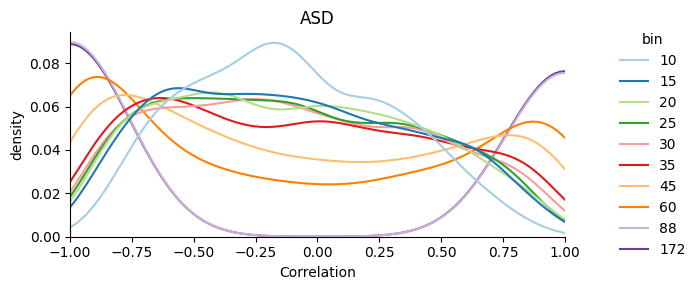

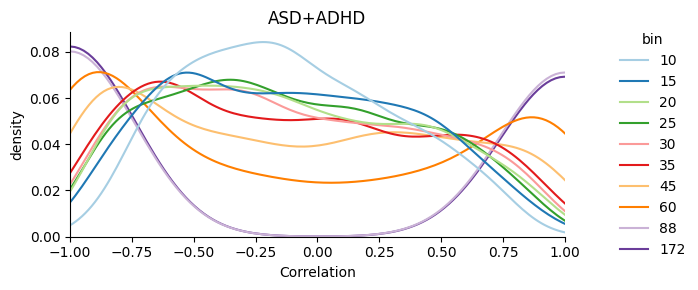

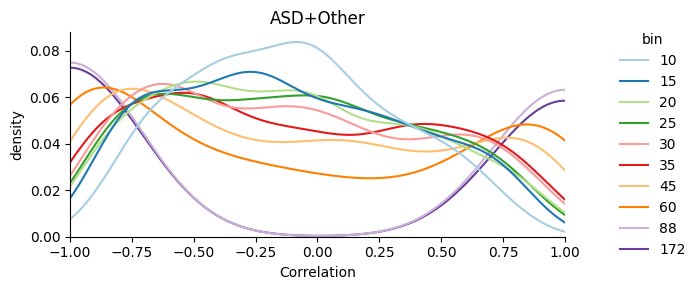

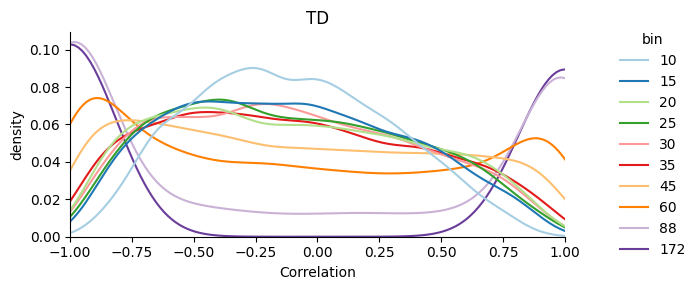

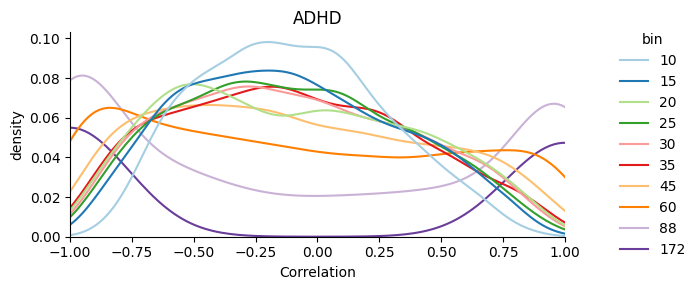

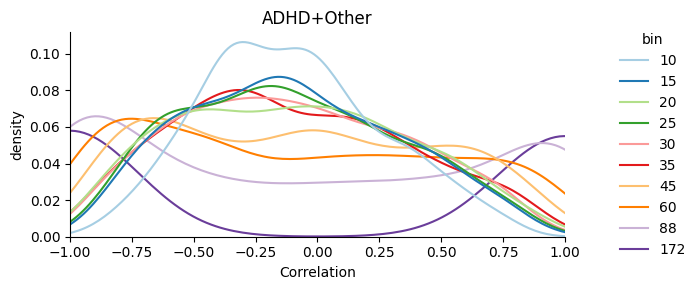

In [21]:
for key, value in coor_data_dict.items():
    temp_data = coor_data_dict[key]
    p = sns.displot(data = temp_data,
                x='Coor_value',
                hue='bin',
                kind="kde",
                palette= "Paired")
    p.set(title=key, xlabel= 'Correlation', ylabel='density', xlim=(-1,1))
    p.fig.set_figwidth(7)
    p.fig.set_figheight(3)
    p.tight_layout()


# Mean and variance pr. timestep

## Mean

We can see that the distributions are very similar, which makes sense since the values have been standardized in the preprocessing step. Furthermore there is only a statistical significats difference between ROI 3 and the diagnosis groups, with a p-value of 0.036. However we have not corrected for multiple hypothesis testing, e.g using the bonferroni correction, thus this is H_1 hypothesis is not accepted - aka. we do not use this hypothesis.

In [22]:
mean_data = pd.read_csv(f'data.nosync/stats/{num_of_rois}_mean_subject.csv', delimiter= ";", index_col = 'Unnamed: 0')
mean_data['subject'] = mean_data['subject'].apply(lambda x: str(x).zfill(7))
mean_data = mean_data.sort_values(['subject', 'dataset'])
mean_data['Sex'] = meta_data.sort_values(['Sub ID', 'Dataset'])['Sex']

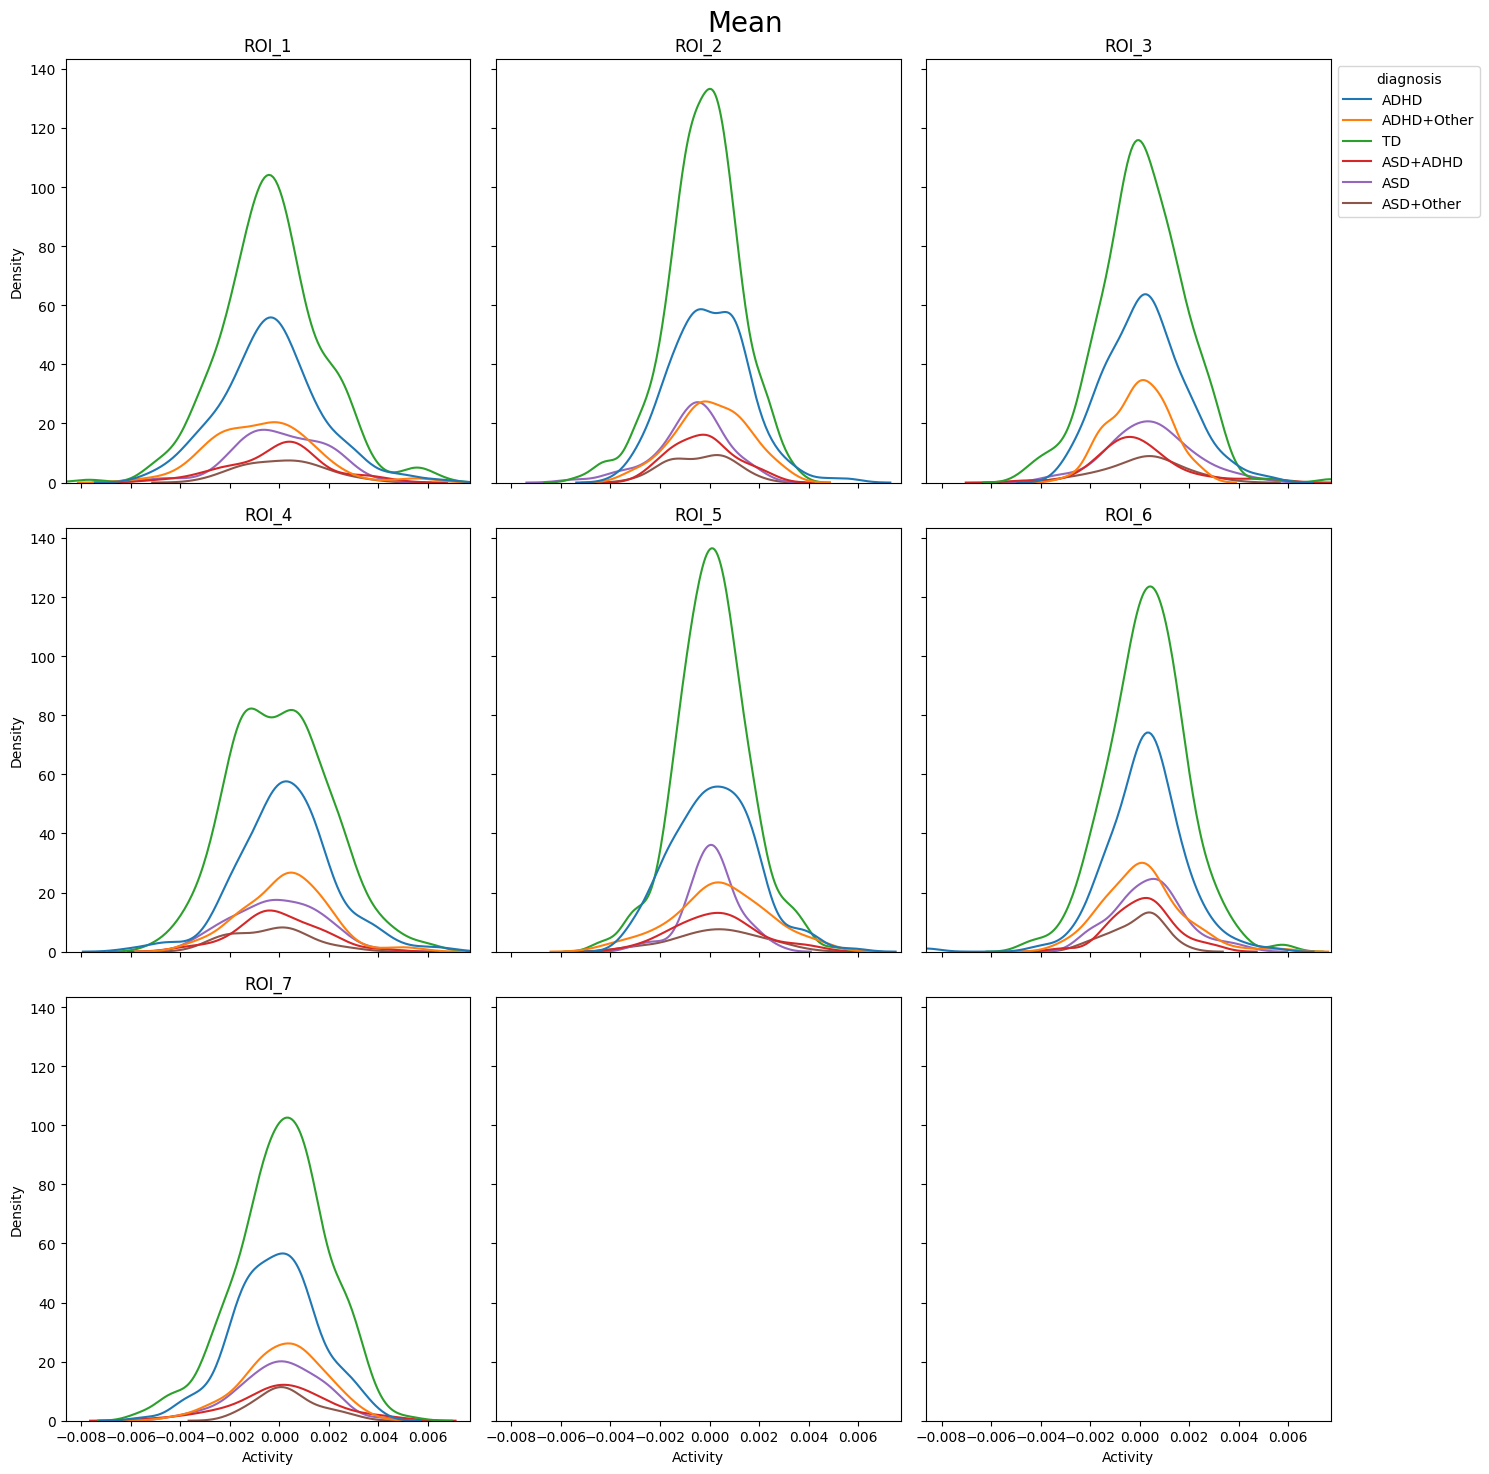

In [23]:
plot_small_multiple_rois(data = mean_data, regions = roi_names , title = 'Mean', hue_col = 'diagnosis')

In [24]:
test_dist(data = mean_data, regions = roi_names)

ROI_1 (Between sex): The P-value is 0.7661719336005534
ROI_2 (Between sex): The P-value is 0.9053046342157026
ROI_3 (Between sex): The P-value is 0.8686226820150986
ROI_4 (Between sex): The P-value is 0.2990304342210649
ROI_5 (Between sex): The P-value is 0.13165437834786284
ROI_6 (Between sex): The P-value is 0.5096427526745436
ROI_7 (Between sex): The P-value is 0.9589200705066966
##################################################
ROI_1 (Between diagnosis): The P-value is 0.3061137286170899
ROI_2 (Between diagnosis): The P-value is 0.01383624048984073
ROI_3 (Between diagnosis): The P-value is 0.6472185778169893
ROI_4 (Between diagnosis): The P-value is 0.5127944837216816
ROI_5 (Between diagnosis): The P-value is 0.7125736752239331
ROI_6 (Between diagnosis): The P-value is 0.6922095263019346
ROI_7 (Between diagnosis): The P-value is 0.6349224843925765


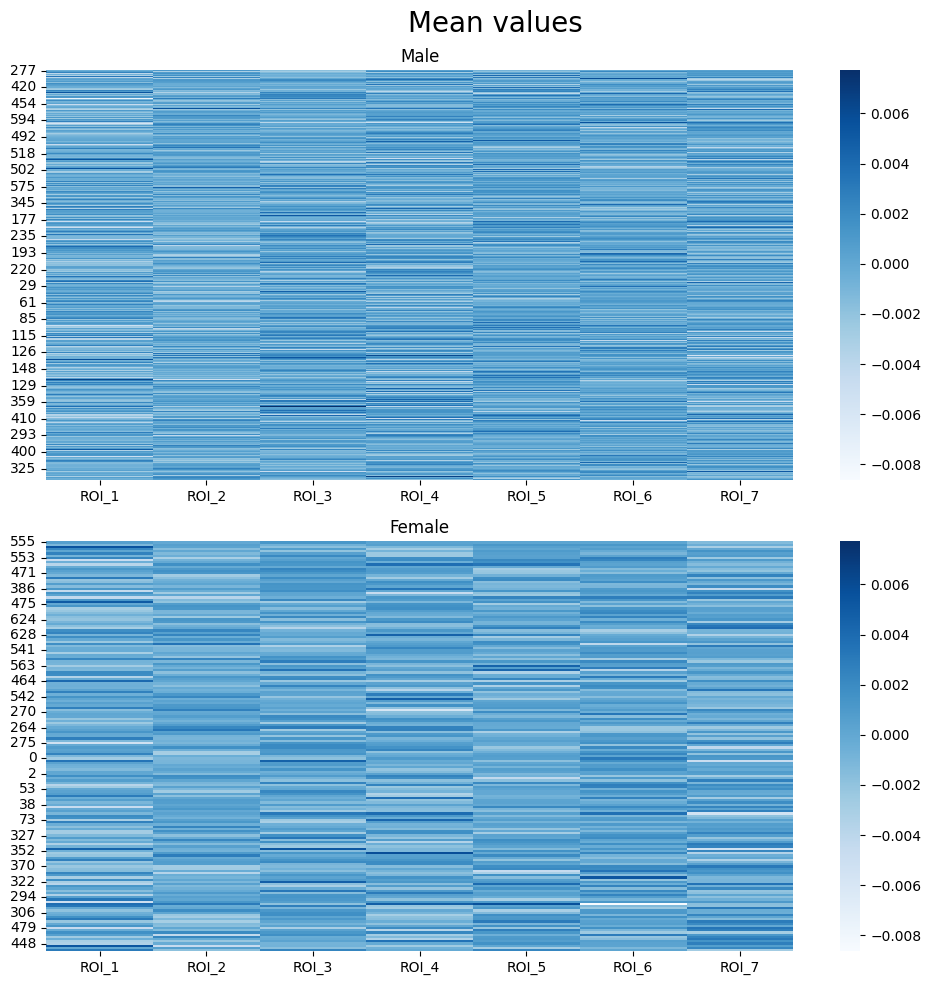

In [25]:
group_roi_heat_map(data = mean_data, group = 'Sex', title = 'Mean values', regions = roi_names)

### Correlation between means difference

Calculating the correlation between the means for each of the ROIs, and substracts them from another group. E.g male vs female participants or diagnosis x vs diagnosis y. 

Take-aways: 
- Note the low sample size does affect the results.
- Between sex
    - We can see that there is differences between the correlation of the means between male participants and female participants.
    - For the TD group the differences are less clear compared to some of the other groups. Here the male participants have a higher correlation between ROI 9 and 14, 15, 16 and 17.
    - The difference between the sexes in the ADHD+Other group are more clear than the TD group. Here the male participants has higher correlation between a ROI 10 and 14, 15, 16 and 17. While the female participants has a higher correlation between ROI 4 and 7 and 9. 
- Between groups
    - We can see that there is differences between the correlation of the means between the different diagnosis (including TD).
    - The ADHD group does differer from both the TD group and ASD. Furtmore there is "more polarized" difference to be spotted between the ADHD and ASD+ADHD. This indicates that there are some differences in which ROIs are "active" (in the sense that these ROIs has mean values that correlates more than other.) at the same time. 


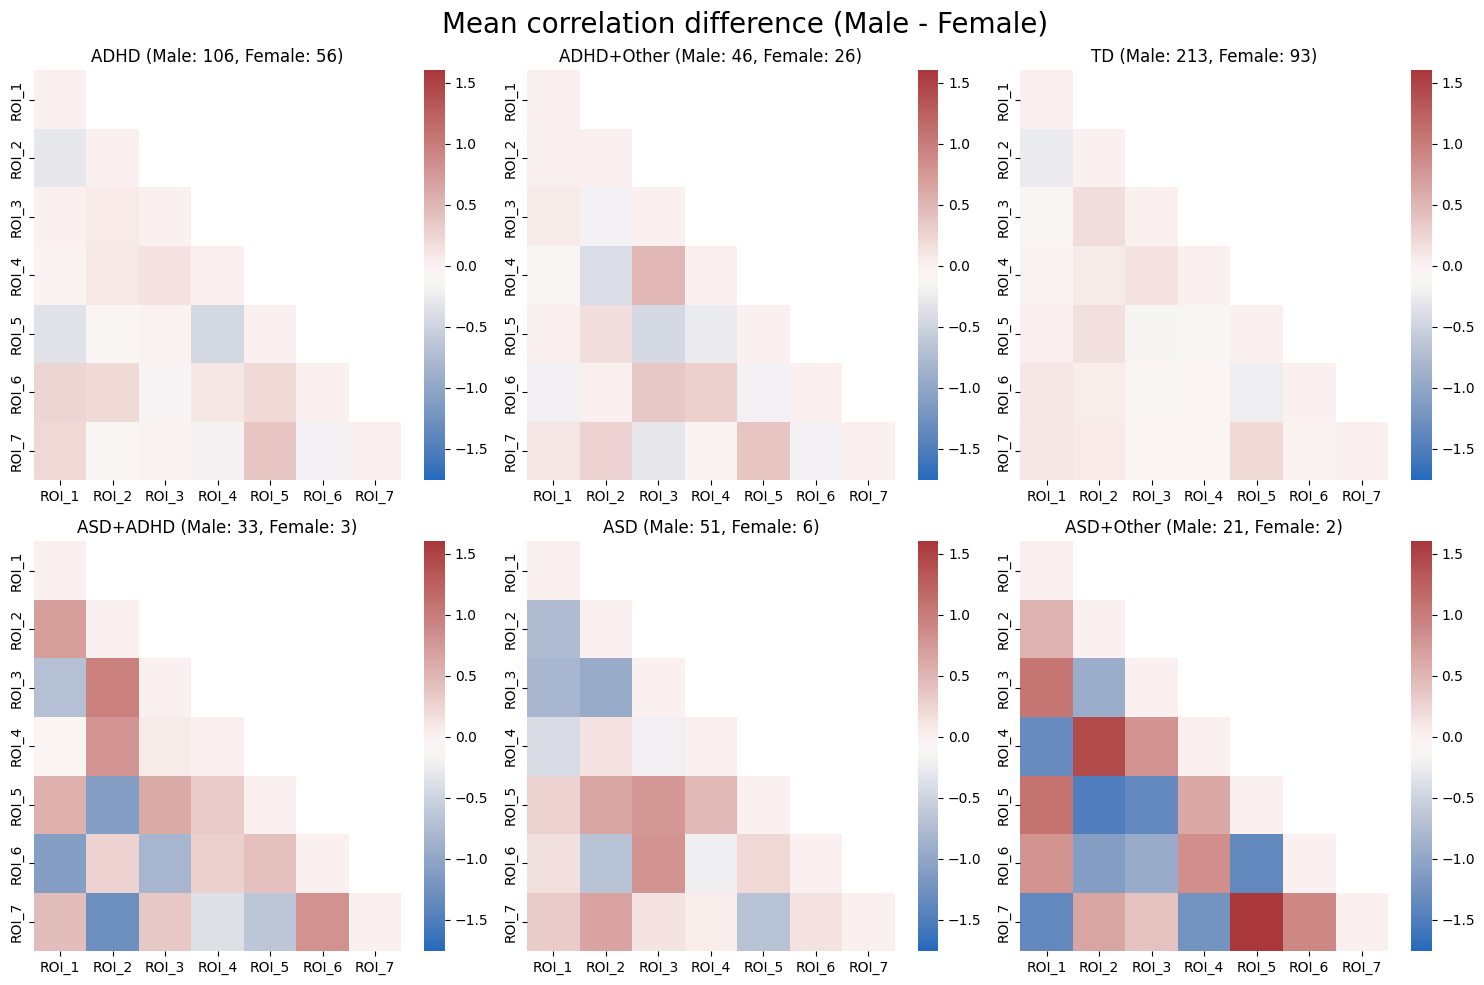

In [26]:
coor_mask = np.triu(np.ones((num_of_rois,num_of_rois), dtype=bool), 1)
color_map = sns.color_palette("vlag", as_cmap=True)

groups = list(mean_data['diagnosis'].unique())

fig, axs = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
fig.suptitle('Mean correlation difference (Male - Female)', fontsize = 20)

ax_pos = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]

for x in range(len(groups)):
        x_pos,y_pos = ax_pos[x]
        temp_data = mean_data[(mean_data['diagnosis'] == groups[x])]
        
        male_data = temp_data[temp_data['Sex'] == "Male"][roi_names]
        coor_male = male_data.corr()
        
        female_data = temp_data[temp_data['Sex'] == "Female"][roi_names]
        coor_female = female_data.corr()
        
        values = coor_male.to_numpy()-coor_female.to_numpy()
        max_value = values.flatten().max()
        #Create subplot
        sns.heatmap(coor_male-coor_female,
                    vmin = 1.6, #max_value,
                    vmax = -1.6, #max_value,
                    mask = coor_mask,
                    cmap = color_map, 
                    ax = axs[x_pos][y_pos])
        axs[x_pos][y_pos].set_title(f"{groups[x]} (Male: {len(male_data)}, Female: {len(female_data)})")


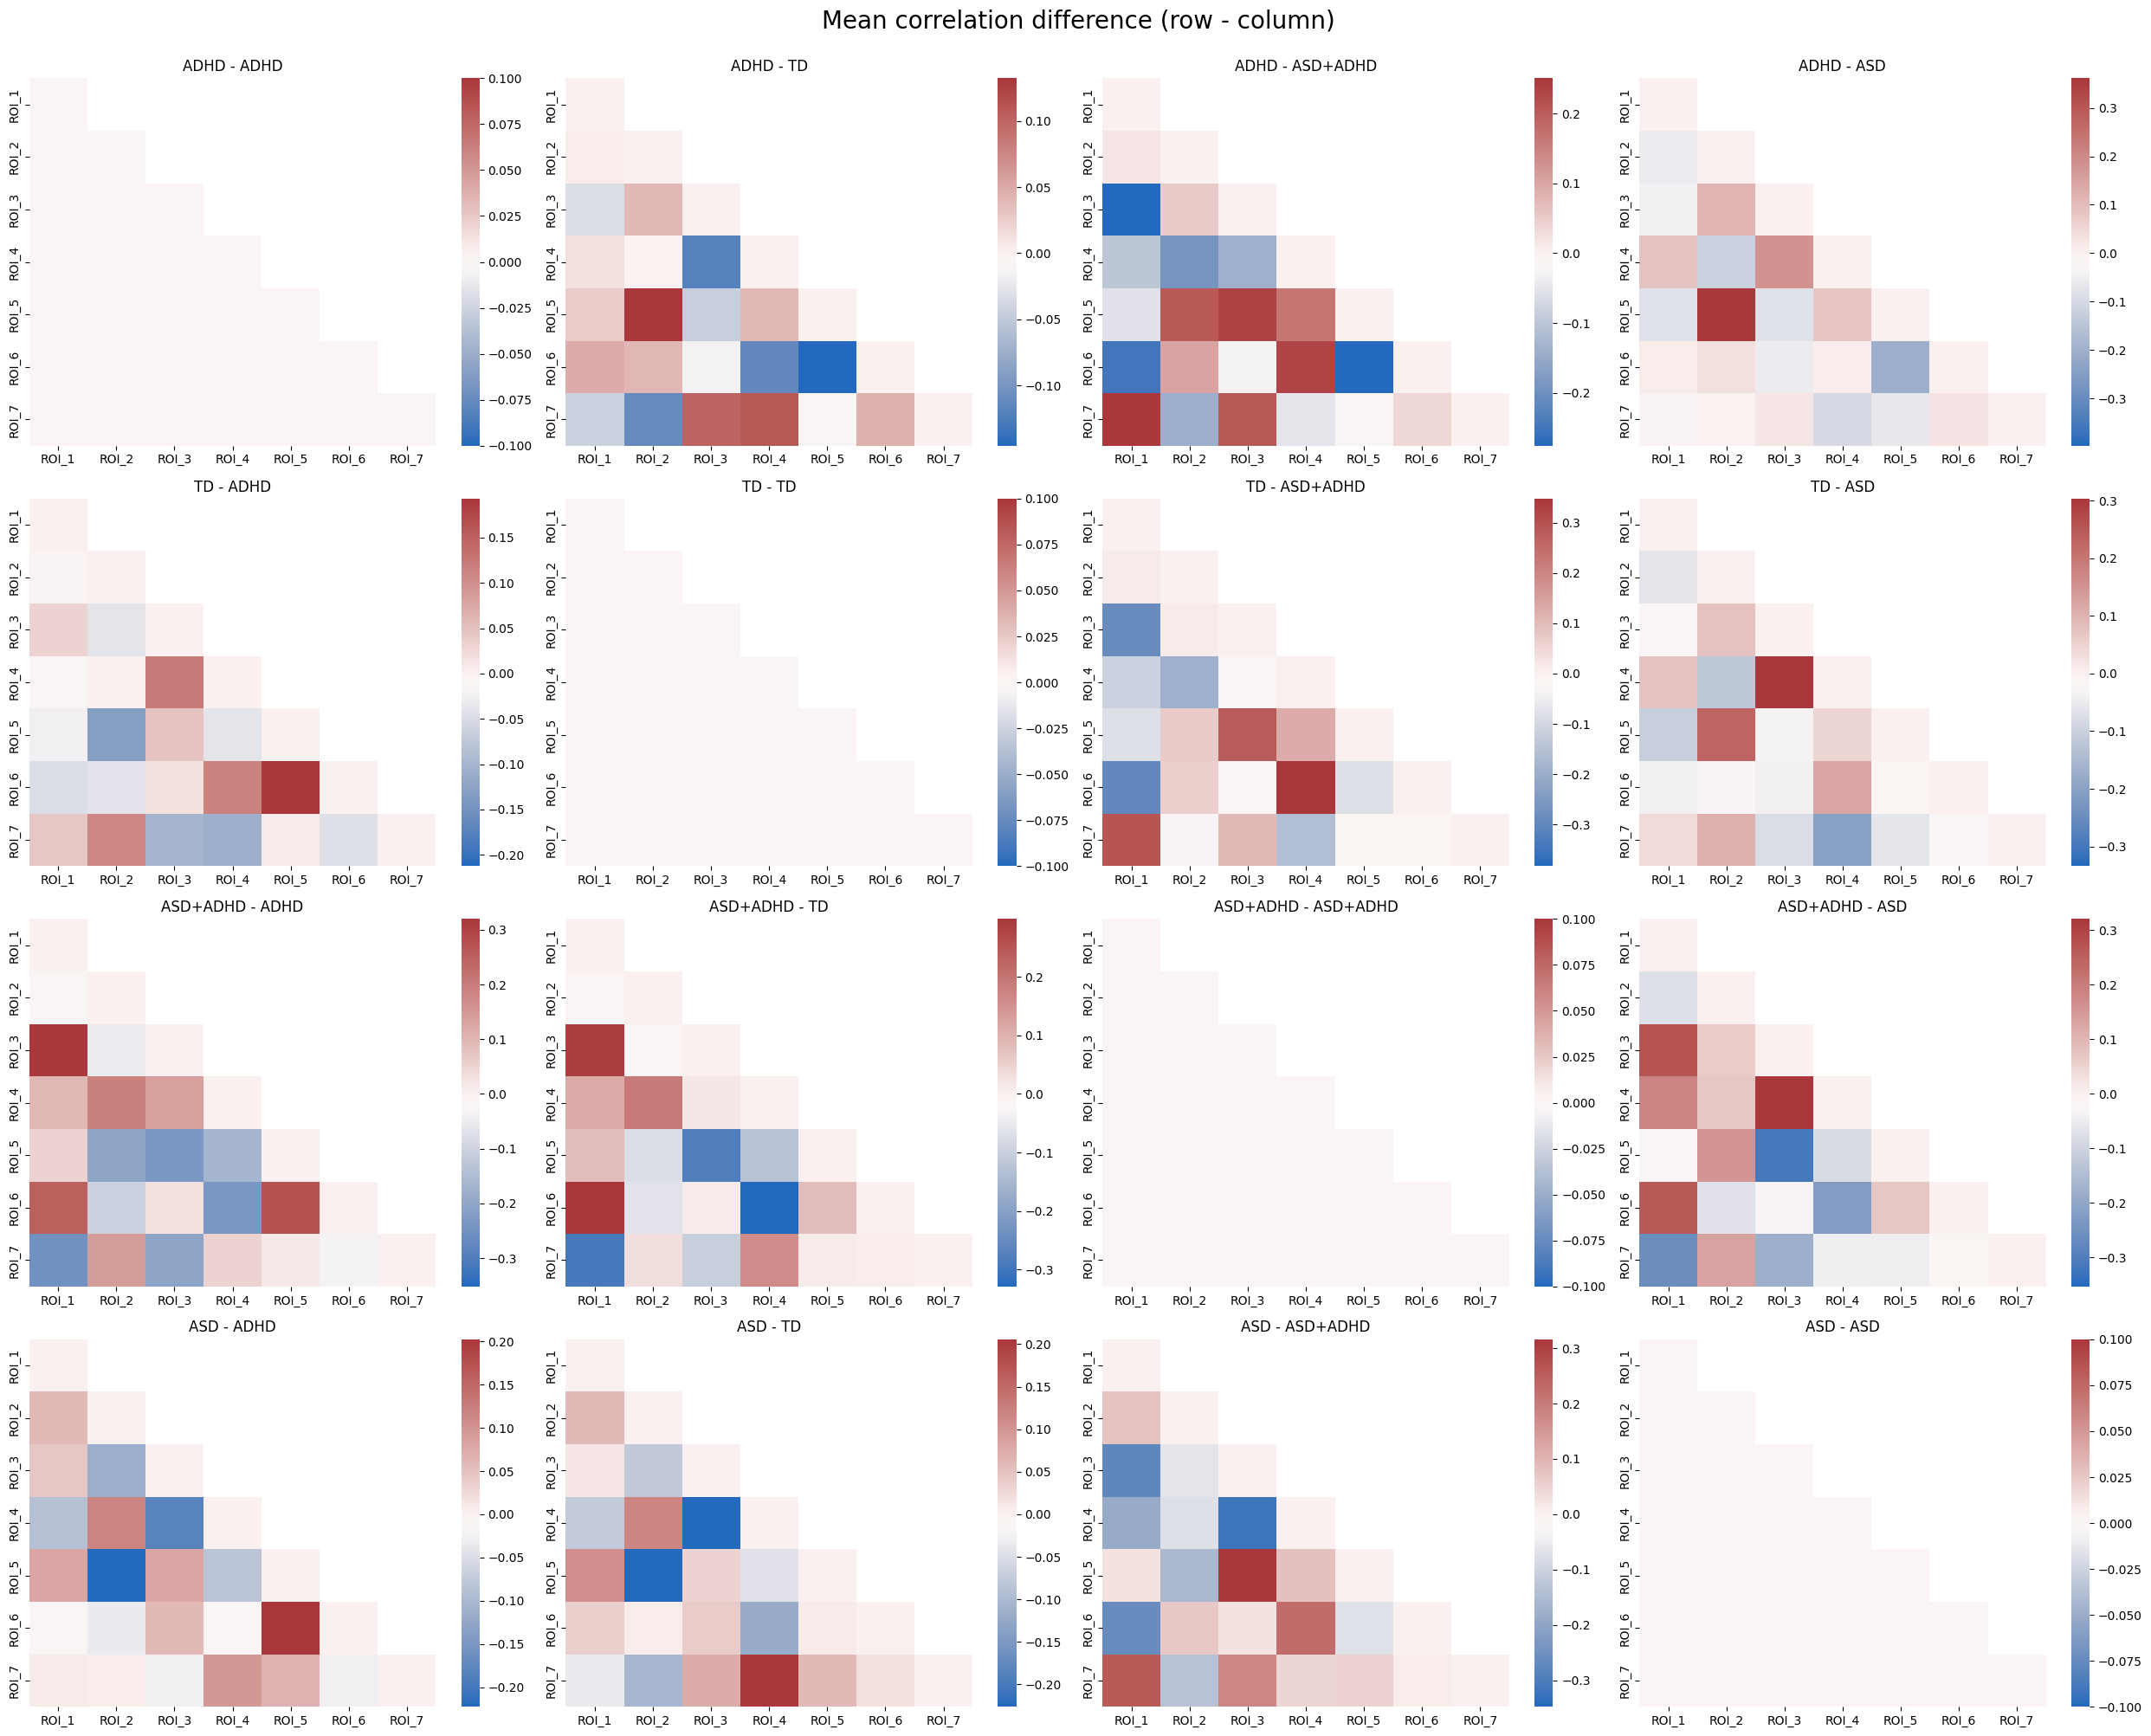

In [27]:
coor_mask = np.triu(np.ones((num_of_rois,num_of_rois), dtype=bool), 1)
color_map = sns.color_palette("vlag", as_cmap=True)
mean_data['short diagnosis'] = mean_data['diagnosis'].apply(lambda x: x.replace('+Other', ''))

groups = list(mean_data['short diagnosis'].unique())

fig, axs = plt.subplots(4, 4, figsize=(25, 20), tight_layout=True)
fig.suptitle('Mean correlation difference (row - column)', fontsize = 20, y = 1)

for g1 in range(len(groups)):
        for g2 in range(len(groups)):

                group_one_data = mean_data[mean_data['short diagnosis'] == groups[g1]][roi_names].corr()
                
                group_two_data = mean_data[mean_data['short diagnosis'] == groups[g2]][roi_names].corr()
                
                values = group_one_data.to_numpy()-group_two_data.to_numpy()
                max_value = values.flatten().max()
                
                #Create subplot
                sns.heatmap(group_one_data-group_two_data,
                        vmin = max_value,
                        vmax = -max_value,
                        mask = coor_mask,
                        cmap = color_map, 
                        ax = axs[g1][g2])
                axs[g1][g2].set_title(f"{groups[g1]} - {groups[g2]}")


## Variance

There are more differene between these distributions, compared to the mean distributions. Furthermore there are many small p-values (>0.01), when looking at the ROIs and the diagnosis. These values does however have to be corrected to avoid p-hacking.

In [28]:
var_data = pd.read_csv(f'data.nosync/stats/{num_of_rois}_variance_subject.csv', delimiter= ";", index_col = 'Unnamed: 0')
var_data['subject'] = var_data['subject'].apply(lambda x: str(x).zfill(7))
var_data = var_data.sort_values(['subject', 'dataset'])
var_data['Sex'] = meta_data.sort_values(['Sub ID', 'Dataset'])['Sex']

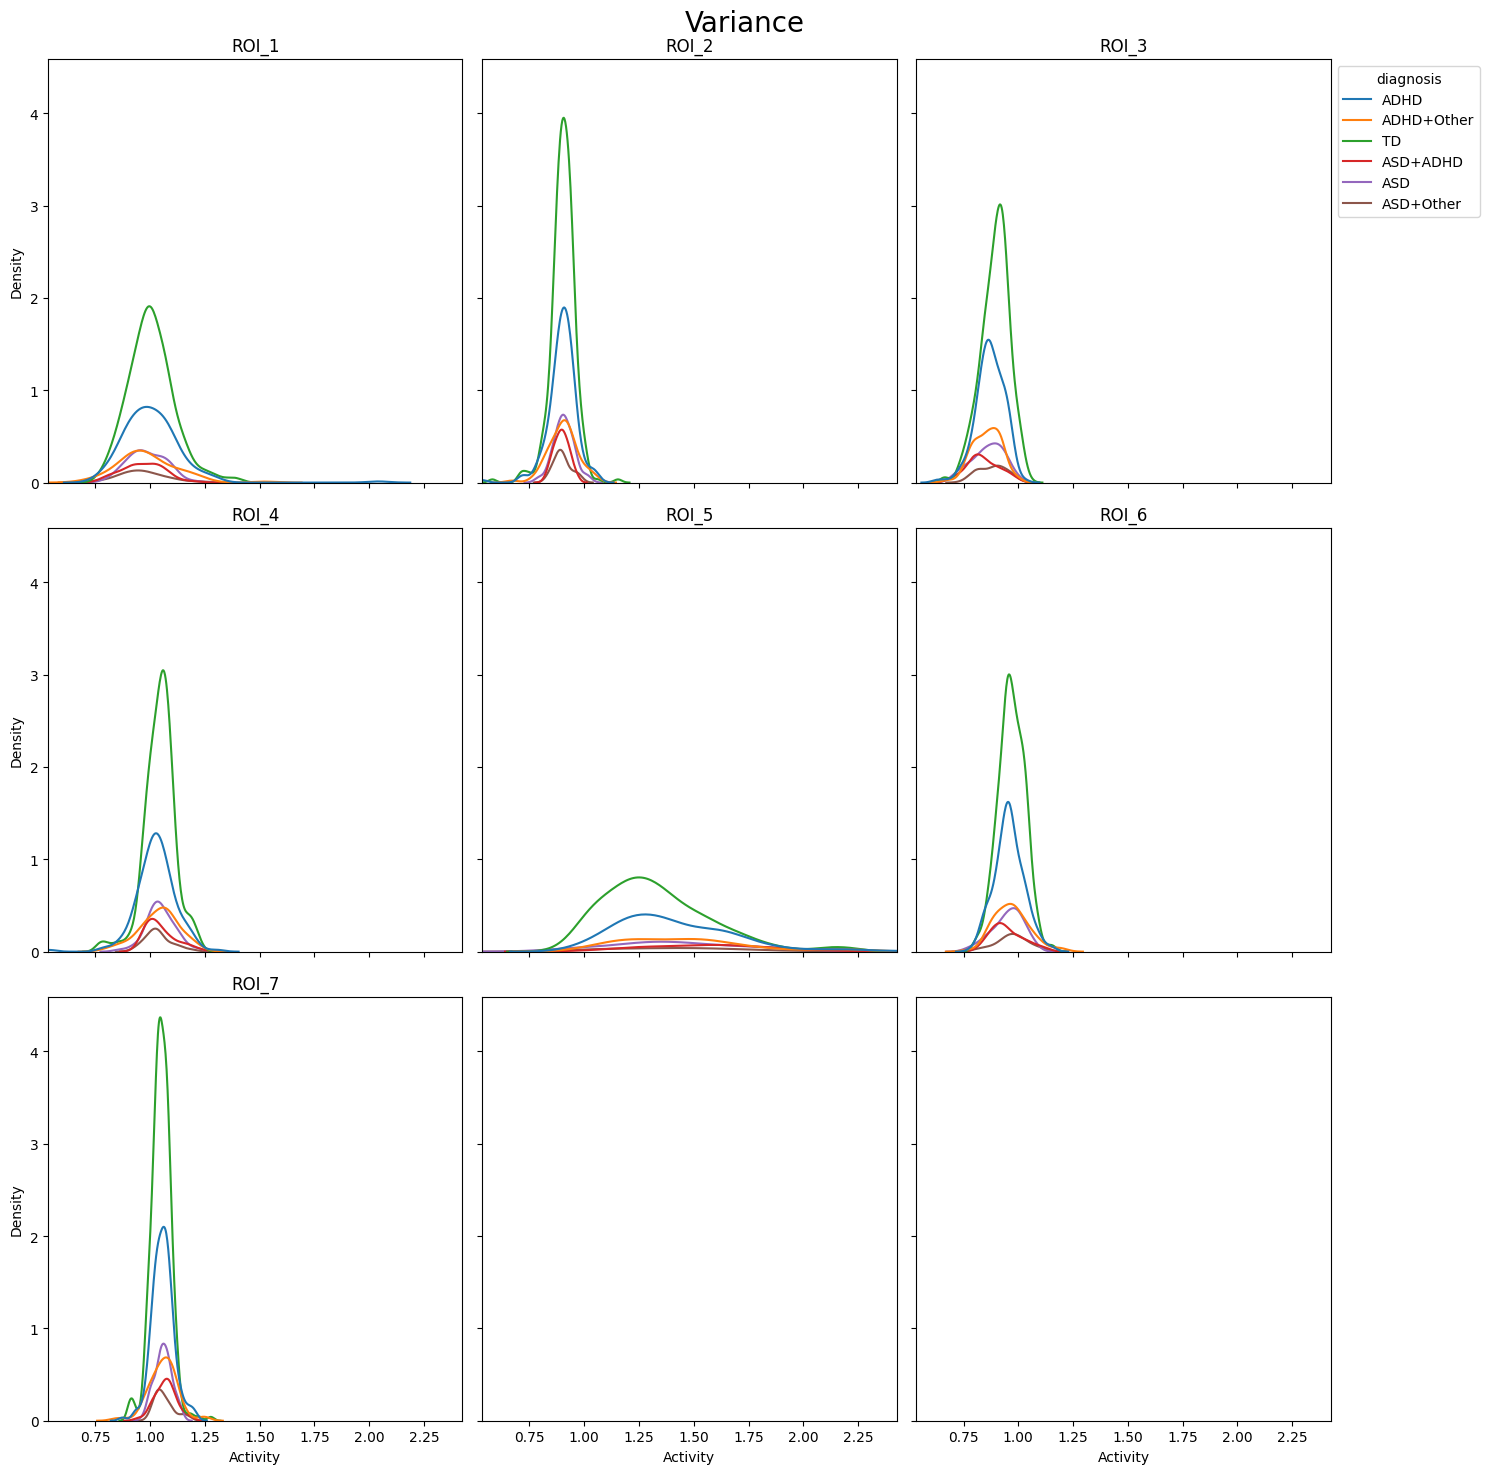

In [29]:
plot_small_multiple_rois(data = var_data, regions = roi_names , title = 'Variance', hue_col = 'diagnosis')

In [30]:
test_dist(data = var_data, regions = roi_names)

ROI_1 (Between sex): The P-value is 0.573402978716774
ROI_2 (Between sex): The P-value is 0.001345475952888508
ROI_3 (Between sex): The P-value is 0.42307508063011623
ROI_4 (Between sex): The P-value is 0.05524092004432368
ROI_5 (Between sex): The P-value is 0.11220327785968014
ROI_6 (Between sex): The P-value is 0.012213089105210772
ROI_7 (Between sex): The P-value is 0.0250900665271447
##################################################
ROI_1 (Between diagnosis): The P-value is 0.11437700089428508
ROI_2 (Between diagnosis): The P-value is 0.9550824394383697
ROI_3 (Between diagnosis): The P-value is 3.570295713938229e-08
ROI_4 (Between diagnosis): The P-value is 0.2912889944707988
ROI_5 (Between diagnosis): The P-value is 3.3796914381700716e-06
ROI_6 (Between diagnosis): The P-value is 0.1734897611216654
ROI_7 (Between diagnosis): The P-value is 0.13618932863508262


### Correlation between variance difference

Calculating the correlation between the variance for each of the ROIs, and substracts them from another group. E.g male vs female participants or diagnosis x vs diagnosis y. 

Take-aways: 
- Note the low sample size does affect the results.
- Between sex
    - Here we (like at the means) sees a difference between the sexes. 
- Between groups
    - Like means we can confirme that there is a difference between the correlation between the groups.


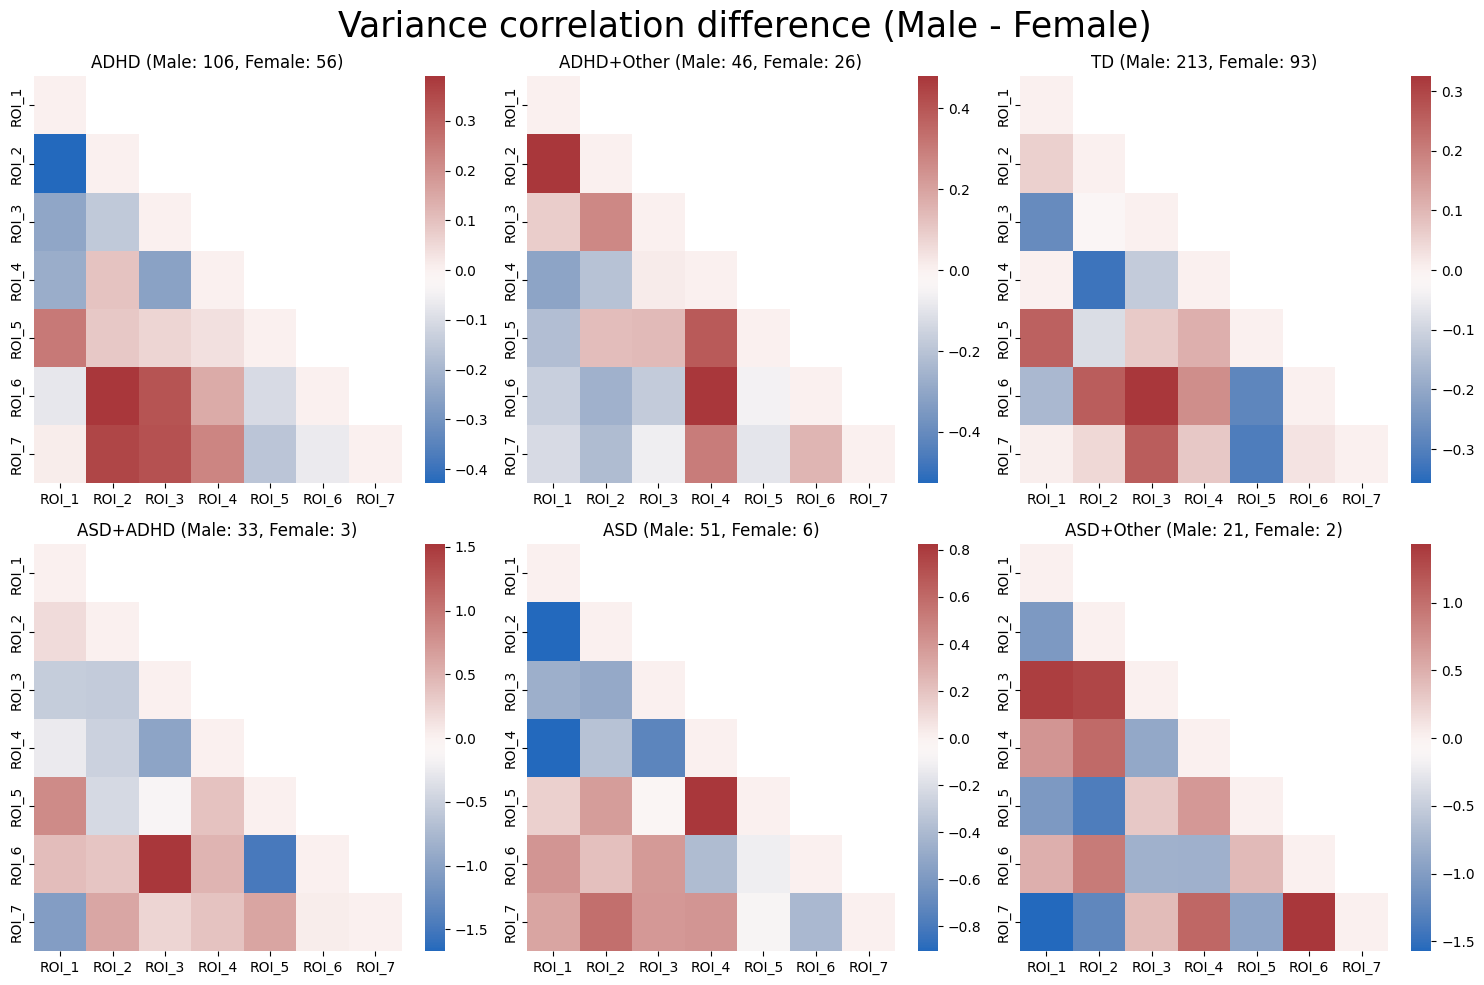

In [31]:
coor_mask = np.triu(np.ones((num_of_rois,num_of_rois), dtype=bool), 1)
color_map = sns.color_palette("vlag", as_cmap=True)

groups = list(var_data['diagnosis'].unique())

fig, axs = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
fig.suptitle('Variance correlation difference (Male - Female)', fontsize = 25)

ax_pos = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]

for x in range(len(groups)):
        x_pos,y_pos = ax_pos[x]
        temp_data = var_data[(var_data['diagnosis'] == groups[x])]
        
        male_data = temp_data[temp_data['Sex'] == "Male"][roi_names]
        coor_male = male_data.corr()
        
        female_data = temp_data[temp_data['Sex'] == "Female"][roi_names]
        coor_female = female_data.corr()
        
        values = coor_male.to_numpy()-coor_female.to_numpy()
        max_value = values.flatten().max()
        #Create subplot
        sns.heatmap(coor_male-coor_female,
                    vmin = max_value,
                    vmax = -max_value,
                    mask = coor_mask,
                    cmap = color_map, 
                    ax = axs[x_pos][y_pos])
        axs[x_pos][y_pos].set_title(f"{groups[x]} (Male: {len(male_data)}, Female: {len(female_data)})")


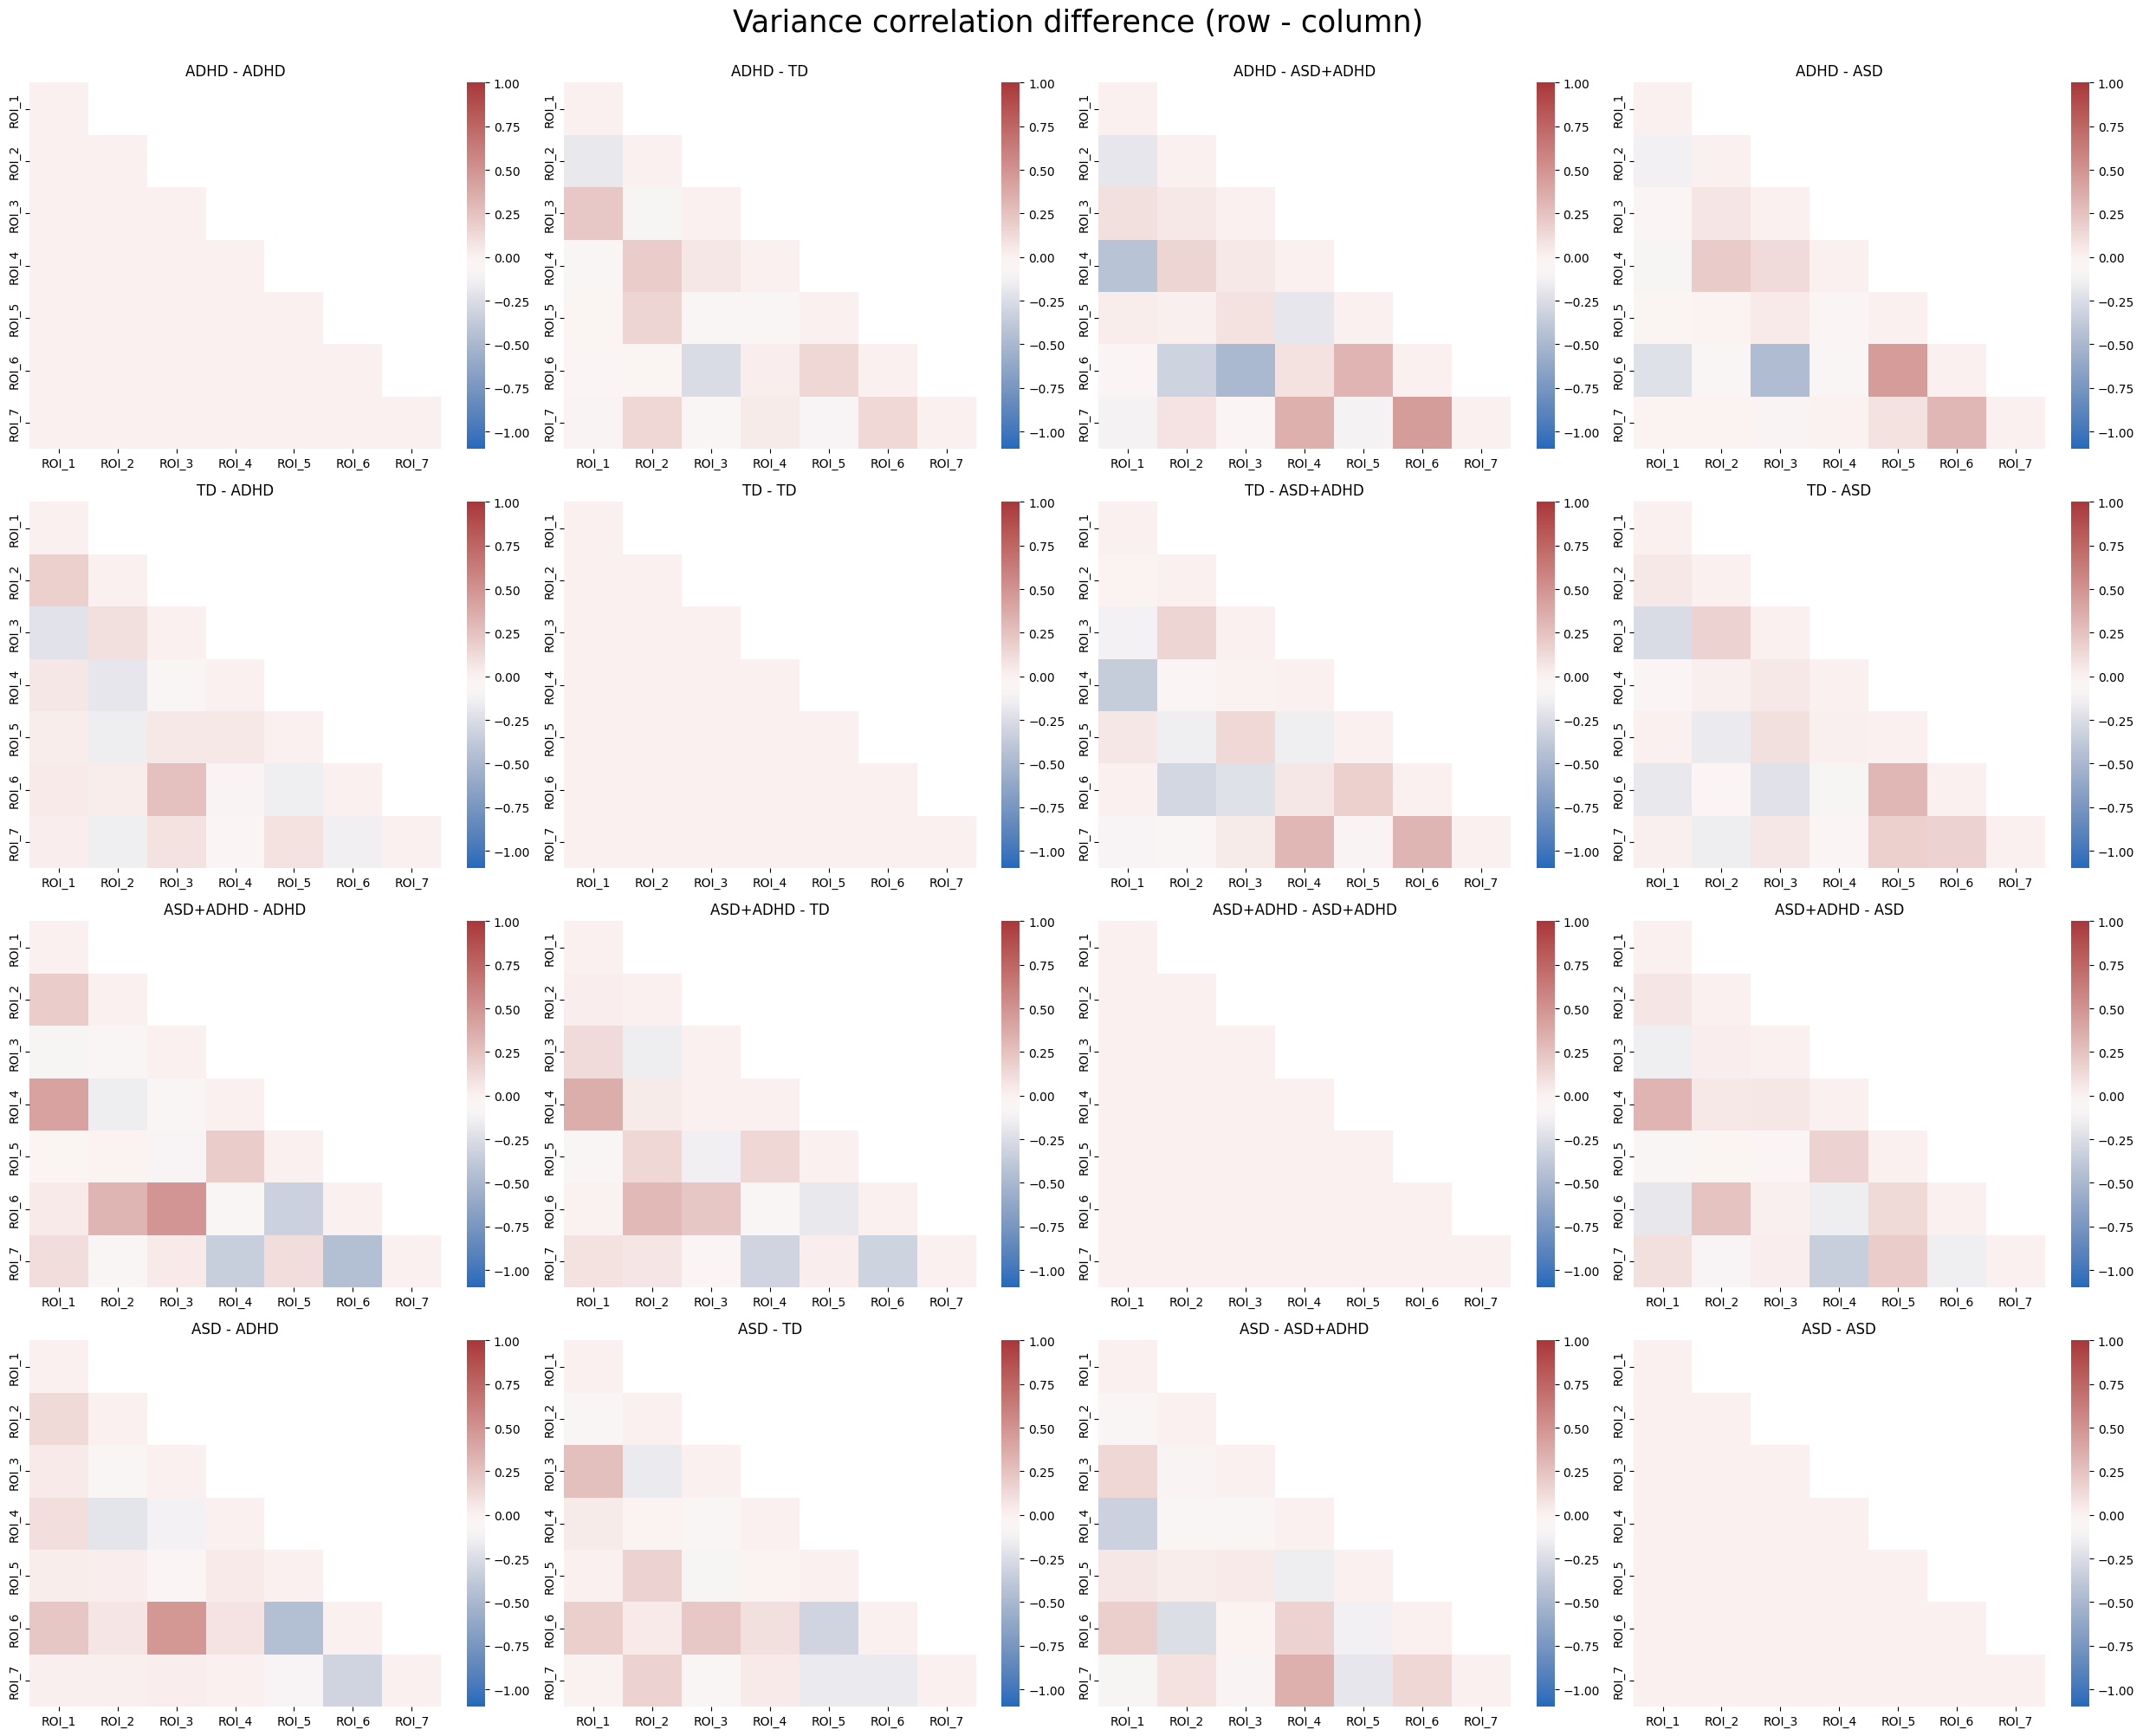

In [32]:
coor_mask = np.triu(np.ones((num_of_rois,num_of_rois), dtype=bool), 1)
color_map = sns.color_palette("vlag", as_cmap=True)
var_data['short diagnosis'] = var_data['diagnosis'].apply(lambda x: x.replace('+Other', ''))

groups = list(var_data['short diagnosis'].unique())

fig, axs = plt.subplots(4, 4, figsize=(25, 20), tight_layout=True)
fig.suptitle('Variance correlation difference (row - column)', fontsize = 25, y = 1)

for g1 in range(len(groups)):
        for g2 in range(len(groups)):

                group_one_data = var_data[var_data['short diagnosis'] == groups[g1]][roi_names].corr()
                
                group_two_data = var_data[var_data['short diagnosis'] == groups[g2]][roi_names].corr()
                
                values = group_one_data.to_numpy()-group_two_data.to_numpy()
                max_value = values.flatten().max()
                
                #Create subplot
                sns.heatmap(group_one_data-group_two_data,
                        vmin = 1,#max_value,
                        vmax = -1, #max_value,
                        mask = coor_mask,
                        cmap = color_map, 
                        ax = axs[g1][g2])
                axs[g1][g2].set_title(f"{groups[g1]} - {groups[g2]}")